In [0]:
#Imports
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
#Azure SQL connection
jdbcUsername = "CloudSA7xxxxx"
jdbcPassword = "xxxxxx"
jdbcHostname = "xxxxxx.database.windows.net"
jdbcPort = 1433
jdbcDatabase = "xxxxxx"

jdbcUrl = f"jdbc:sqlserver://{jdbcHostname}:{jdbcPort};database={jdbcDatabase}"
connectionProperties = {
    "user": jdbcUsername,
    "password": jdbcPassword,
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

In [0]:
#Validating tables first rows
sqlc = "(SELECT * FROM companies) AS tmp"
sqld = "(SELECT * FROM dates) AS tmp"
sqls = "(SELECT * FROM stock_prices) AS tmp"

try:
    df_companies = spark.read.jdbc(url=jdbcUrl, table=sqlc, properties=connectionProperties)
    df_dates = spark.read.jdbc(url=jdbcUrl, table=sqld, properties=connectionProperties)
    df_prices = spark.read.jdbc(url=jdbcUrl, table=sqls, properties=connectionProperties) 
except AnalysisException as e:
    print(f"Error: {e}")

df_companies.show(15) 
df_dates.show(15) 
df_prices.show(15) 

+------------+--------------------+
|stock_symbol|             company|
+------------+--------------------+
|        AAPL|          Apple Inc.|
|        ADBE|          Adobe Inc.|
|        AMZN|    Amazon.com, Inc.|
|         CRM|    Salesforce, Inc.|
|        CSCO| Cisco Systems, Inc.|
|       GOOGL|       Alphabet Inc.|
|         IBM|International Bus...|
|        INTC|   Intel Corporation|
|        META|Meta Platforms, Inc.|
|        MSFT|Microsoft Corpora...|
|        NFLX|       Netflix, Inc.|
|        NVDA|  NVIDIA Corporation|
|        ORCL|  Oracle Corporation|
|        TSLA|         Tesla, Inc.|
+------------+--------------------+

+--------+----+------+-------------------+
|      id|year| month|          full_date|
+--------+----+------+-------------------+
|20100104|2010|201001|2010-01-04 00:00:00|
|20100105|2010|201001|2010-01-05 00:00:00|
|20100106|2010|201001|2010-01-06 00:00:00|
|20100107|2010|201001|2010-01-07 00:00:00|
|20100108|2010|201001|2010-01-08 00:00:00|
|201001

In [0]:
#Validating number of rows of campanies and stock_prices tables
sqlc = "(SELECT COUNT(*) AS rows FROM companies) AS tmp"
sqls = "(SELECT COUNT(*) AS rows FROM stock_prices) AS tmp"

try:
    df1 = spark.read.jdbc(url=jdbcUrl, table=sqlc, properties=connectionProperties)
    df2 = spark.read.jdbc(url=jdbcUrl, table=sqls, properties=connectionProperties) 
except AnalysisException as e:
    print(f"Error: {e}")

print("companies:")
df1.show()

print("prices:")
df2.show() 

companies:
+----+
|rows|
+----+
|  14|
+----+

prices:
+-----+
| rows|
+-----+
|45088|
+-----+



In [0]:
#Validating number of rows of dates table
sqlp = "(SELECT COUNT(DISTINCT date) AS expected_rows FROM stock_prices) AS tmp"
sqld = "(SELECT COUNT(*) AS rows FROM dates) AS tmp"

try:
    df1 = spark.read.jdbc(url=jdbcUrl, table=sqlp, properties=connectionProperties)
    df2 = spark.read.jdbc(url=jdbcUrl, table=sqld, properties=connectionProperties) 
except AnalysisException as e:
    print(f"Error: {e}")

print("dates:")
df1.show()
df2.show() 

dates:
+-------------+
|expected_rows|
+-------------+
|         3287|
+-------------+

+----+
|rows|
+----+
|3287|
+----+



In [0]:
#Validating date range
sql = """
    (SELECT
        b.company, 
        min(c.full_date) as dtMin,
        max(c.full_date) as dtMax
    FROM stock_prices a
    INNER JOIN companies b ON a.stock_symbol = b.stock_symbol
    INNER JOIN dates c ON a.date = c.id
    GROUP BY 
        b.company) AS tmp
"""

try:
    df = spark.read.jdbc(url=jdbcUrl, table=sql, properties=connectionProperties)
except AnalysisException as e:
    print(f"Error: {e}")

df.show()

+--------------------+-------------------+-------------------+
|             company|              dtMin|              dtMax|
+--------------------+-------------------+-------------------+
|          Adobe Inc.|2010-01-04 00:00:00|2022-12-29 00:00:00|
|       Alphabet Inc.|2010-01-04 00:00:00|2022-12-29 00:00:00|
|    Amazon.com, Inc.|2010-01-04 00:00:00|2022-12-29 00:00:00|
|          Apple Inc.|2010-01-04 00:00:00|2022-12-29 00:00:00|
| Cisco Systems, Inc.|2010-01-04 00:00:00|2022-12-29 00:00:00|
|   Intel Corporation|2010-01-04 00:00:00|2022-12-29 00:00:00|
|International Bus...|2010-01-04 00:00:00|2022-12-29 00:00:00|
|Meta Platforms, Inc.|2012-05-18 00:00:00|2023-01-24 00:00:00|
|Microsoft Corpora...|2010-01-04 00:00:00|2022-12-29 00:00:00|
|       Netflix, Inc.|2010-01-04 00:00:00|2022-12-29 00:00:00|
|  NVIDIA Corporation|2010-01-04 00:00:00|2022-12-29 00:00:00|
|  Oracle Corporation|2010-01-04 00:00:00|2022-12-29 00:00:00|
|    Salesforce, Inc.|2010-01-04 00:00:00|2022-12-29 00

In [0]:
#Validating if there are null values
sql = """
    (SELECT * FROM stock_prices) AS tmp
"""
try:
    df = spark.read.jdbc(url=jdbcUrl, table=sql, properties=connectionProperties)

    for column in df.columns:
        null_count = df.filter(df[column].isNull()).count()
        print(f"Coluna '{column}' tem {null_count} valores nulos.")

except AnalysisException as e:
    print(f"Erro ao executar a consulta SQL: {e}")

Coluna 'stock_symbol' tem 0 valores nulos.
Coluna 'date' tem 0 valores nulos.
Coluna 'open' tem 0 valores nulos.
Coluna 'high' tem 0 valores nulos.
Coluna 'low' tem 0 valores nulos.
Coluna 'close' tem 0 valores nulos.
Coluna 'adj_close' tem 0 valores nulos.
Coluna 'volume' tem 0 valores nulos.


In [0]:
#Validating if there are null values
sql = """
    (SELECT * FROM companies) AS tmp
"""
try:
    df = spark.read.jdbc(url=jdbcUrl, table=sql, properties=connectionProperties)

    for column in df.columns:
        null_count = df.filter(df[column].isNull()).count()
        print(f"Coluna '{column}' tem {null_count} valores nulos.")

except AnalysisException as e:
    print(f"Erro ao executar a consulta SQL: {e}")

Coluna 'stock_symbol' tem 0 valores nulos.
Coluna 'company' tem 0 valores nulos.


In [0]:
#Validating if there are null values
sql = """
    (SELECT * FROM dates) AS tmp
"""
try:
    df = spark.read.jdbc(url=jdbcUrl, table=sql, properties=connectionProperties)

    for column in df.columns:
        null_count = df.filter(df[column].isNull()).count()
        print(f"Coluna '{column}' tem {null_count} valores nulos.")

except AnalysisException as e:
    print(f"Erro ao executar a consulta SQL: {e}")

Coluna 'id' tem 0 valores nulos.
Coluna 'year' tem 0 valores nulos.
Coluna 'month' tem 0 valores nulos.
Coluna 'full_date' tem 0 valores nulos.


In [0]:
#1. What is the maximum and minimum stock price each company reached in the last three years?
sql = """
    (SELECT TOP 100
        b.company, 
        MAX(a.high) AS high, 
        MIN(a.low) AS low,
        c.year
    FROM stock_prices a
    INNER JOIN companies b ON a.stock_symbol = b.stock_symbol
    INNER JOIN dates c ON a.date = c.id
    WHERE c.year IN (2020, 2021, 2022)
    GROUP BY 
        b.company,
        c.year
    ORDER BY 
        b.company,
        c.year) AS tmp
"""

try:
    results = spark.read.jdbc(url=jdbcUrl, table=sql, properties=connectionProperties)
except AnalysisException as e:
    print(f"Error: {e}")

results.show(100)

+--------------------+---------+---------+----+
|             company|     high|      low|year|
+--------------------+---------+---------+----+
|          Adobe Inc.|   536.88|   255.13|2020|
|          Adobe Inc.|   699.54|   420.78|2021|
|          Adobe Inc.|    575.0|   274.73|2022|
|       Alphabet Inc.|  92.1915|  50.4435|2020|
|       Alphabet Inc.| 150.9665|   84.805|2021|
|       Alphabet Inc.| 151.5465|    83.34|2022|
|    Amazon.com, Inc.| 177.6125|  81.3015|2020|
|    Amazon.com, Inc.|  188.654|   144.05|2021|
|    Amazon.com, Inc.|    171.4|    81.69|2022|
|          Apple Inc.|   138.79|  53.1525|2020|
|          Apple Inc.|   182.13|   116.21|2021|
|          Apple Inc.|   182.94|   125.87|2022|
| Cisco Systems, Inc.|    50.28|     32.4|2020|
| Cisco Systems, Inc.|    64.29|    43.35|2021|
| Cisco Systems, Inc.|    63.35|     38.6|2022|
|   Intel Corporation|    69.29|    43.61|2020|
|   Intel Corporation|    68.49|    47.87|2021|
|   Intel Corporation|    56.28|    24.5

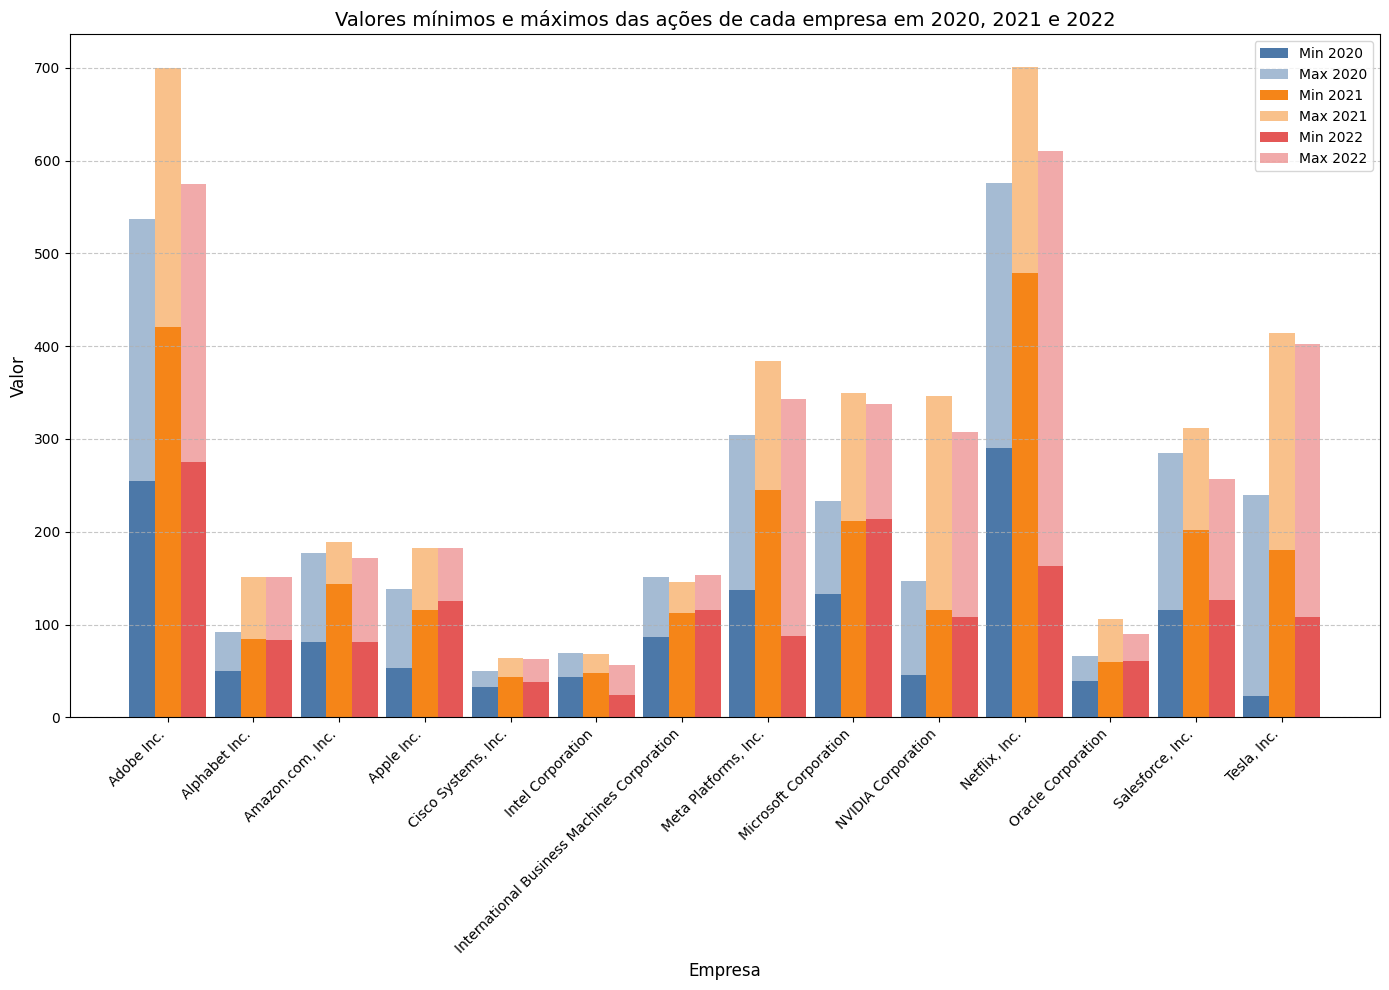

In [0]:
# graphical representation of the results
results_pd = results.toPandas()

grouped = results_pd.groupby(['company', 'year']).agg({'high': 'max', 'low': 'min'}).reset_index()

companies = grouped['company'].unique()
years = grouped['year'].unique()
bar_width = 0.3
bar_positions = range(len(companies))
colors = ['#4c78a8', '#f58518', '#e45756']

fig, ax = plt.subplots(figsize=(14, 10))

for i, year in enumerate(years):
    year_data = grouped[grouped['year'] == year]
    highs = year_data['high']
    lows = year_data['low']
    
    ax.bar([pos + i * bar_width for pos in bar_positions], lows, width=bar_width, label=f'Min {year}', color=colors[i])
    ax.bar([pos + i * bar_width for pos in bar_positions], highs - lows, width=bar_width, bottom=lows, label=f'Max {year}', color=colors[i], alpha=0.5)

ax.set_xlabel('Empresa', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)
ax.set_title('Valores mínimos e máximos das ações de cada empresa em 2020, 2021 e 2022', fontsize=14)
ax.set_xticks([pos + (len(years) - 1) * bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(companies, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=10)

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [0]:
#2. Did the pandemic had any impact on the stock prices of these companies?
#Comparing the average stock prices in 2019 (pre-pandemic) with the average stock prices in 2020 (during the pandemic)

sql = """
    (SELECT TOP 100
        b.company, 
        AVG(a.[adj_close]) AS avg_price,
        c.year
    FROM stock_prices a
    INNER JOIN companies b ON a.stock_symbol = b.stock_symbol
    INNER JOIN dates c ON a.date = c.id
    WHERE c.year IN (2019, 2020) 
    GROUP BY 
        b.company,
        c.year
    ORDER BY 
        b.company,
        c.year) AS tmp
"""

try:
    results = spark.read.jdbc(url=jdbcUrl, table=sql, properties=connectionProperties)
except AnalysisException as e:
    print(f"Error: {e}")

results.show(100)

+--------------------+------------------+----+
|             company|         avg_price|year|
+--------------------+------------------+----+
|          Adobe Inc.|  279.322818150596|2019|
|          Adobe Inc.| 415.9712655892956|2020|
|       Alphabet Inc.|59.560847131032794|2019|
|       Alphabet Inc.|  73.9496560530229|2020|
|    Amazon.com, Inc.|  89.4594602433462|2019|
|    Amazon.com, Inc.|134.04275452383894|2020|
|          Apple Inc.|50.702359820169114|2019|
|          Apple Inc.| 93.91639358158639|2020|
| Cisco Systems, Inc.|45.204785256158736|2019|
| Cisco Systems, Inc.| 39.73812596317337|2020|
|   Intel Corporation| 46.48002757723369|2019|
|   Intel Corporation|50.790813732524164|2020|
|International Bus...|110.40913067166767|2019|
|International Bus...|105.11702453854527|2020|
|Meta Platforms, Inc.| 181.6374996124752|2019|
|Meta Platforms, Inc.|234.55086984747484|2020|
|Microsoft Corpora...|125.93545638190375|2019|
|Microsoft Corpora...| 188.7167906026124|2020|
|       Netfl

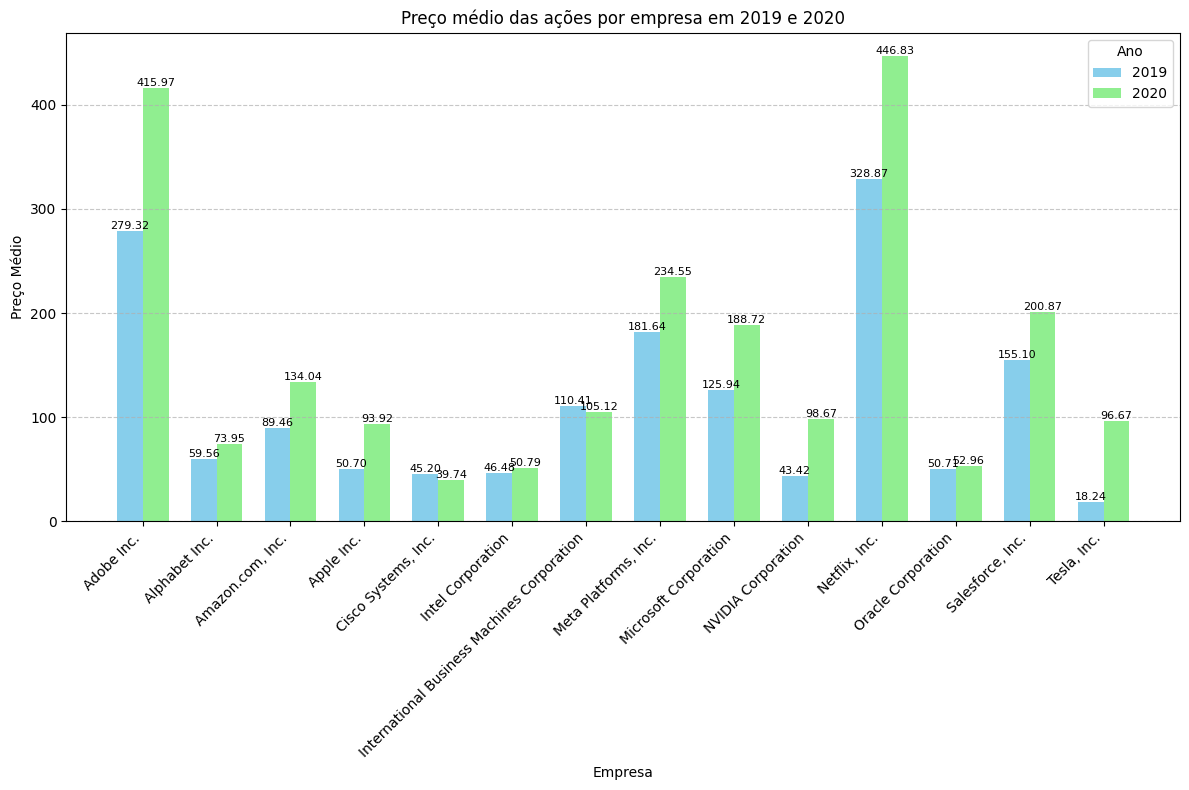

In [0]:
# graphical representation of the results
results_pd = results.toPandas()

results_pd['year'] = results_pd['year'].astype(str)

pivot_df = results_pd.pivot_table(index='company', columns='year', values='avg_price', aggfunc='mean')

plt.figure(figsize=(12, 8))
bar_width = 0.35
r1 = range(len(companies))
r2 = [x + bar_width for x in r1]

bars_2019 = plt.bar(r1, pivot_df['2019'], width=bar_width, label='2019', color='skyblue')
bars_2020 = plt.bar(r2, pivot_df['2020'], width=bar_width, label='2020', color='lightgreen')

for idx, bar_2019, bar_2020 in zip(r1, bars_2019, bars_2020):
    plt.text(bar_2019.get_x() + bar_2019.get_width() / 2, bar_2019.get_height(), '{:.2f}'.format(pivot_df.loc[companies[idx], '2019']),
                ha='center', va='bottom', color='black', fontsize=8)
    plt.text(bar_2020.get_x() + bar_2020.get_width() / 2, bar_2020.get_height(), '{:.2f}'.format(pivot_df.loc[companies[idx], '2020']),
                ha='center', va='bottom', color='black', fontsize=8)

plt.title('Preço médio das ações por empresa em 2019 e 2020')
plt.xlabel('Empresa')
plt.ylabel('Preço Médio')
plt.xticks([r + bar_width / 2 for r in range(len(companies))], companies, rotation=45, ha='right')
plt.legend(title='Ano')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [0]:
#3. How much did each company's stocks appreciate over 10 years?
# Calculating the difference in stock prices between January 2010 and January 2020
# The 'growth' field represents the percentage (%) increase in the stock value.

sql = """
    (SELECT TOP 100
        a.company,
        MAX(a.value_2010) AS value_2010,
        MAX(a.value_2020) AS value_2020,
        ((MAX(a.value_2020) - MAX(a.value_2010)) / MAX(a.value_2010)) * 100 AS growth
    FROM (
        SELECT 
            b.company, 
            CASE WHEN c.full_date = '2010-01-29' THEN a.adj_close ELSE NULL END AS value_2010,
            CASE WHEN c.full_date = '2020-01-29' THEN a.adj_close ELSE NULL END AS value_2020
        FROM stock_prices a
        INNER JOIN companies b ON a.stock_symbol = b.stock_symbol
        INNER JOIN dates c ON a.date = c.id
        WHERE c.full_date IN ('2010-01-29', '2020-01-29')
    ) AS a
    GROUP BY a.company
    ORDER BY ((MAX(a.value_2020) - MAX(a.value_2010)) / MAX(a.value_2010)) * 100 DESC
    ) AS tmp
"""

try:
    results = spark.read.jdbc(url=jdbcUrl, table=sql, properties=connectionProperties)
except AnalysisException as e:
    print(f"Error: {e}")

results.show(100)

+--------------------+----------+----------+---------+
|             company|value_2010|value_2020|   growth|
+--------------------+----------+----------+---------+
|       Netflix, Inc.|  8.892857|    343.16|3758.8276|
|  NVIDIA Corporation|  3.531051| 61.173195| 1632.436|
|    Amazon.com, Inc.|    6.2705|      92.9|1381.5405|
|          Apple Inc.|  5.846978|  79.43714|1258.6017|
|    Salesforce, Inc.|   15.8875|    181.77| 1044.107|
|          Adobe Inc.|      32.3|    351.66| 988.7307|
|Microsoft Corpora...| 21.563454| 163.36554| 657.6038|
|       Alphabet Inc.| 13.261762|    72.835| 449.2106|
|   Intel Corporation| 13.026489| 60.676655|365.79437|
| Cisco Systems, Inc.| 15.830134| 42.818954|170.49014|
|  Oracle Corporation| 19.295464| 50.644123|162.46648|
|International Bus...| 75.138626|   113.457|50.996906|
|         Tesla, Inc.|      NULL| 38.732666|     NULL|
|Meta Platforms, Inc.|      NULL|    223.23|     NULL|
+--------------------+----------+----------+---------+



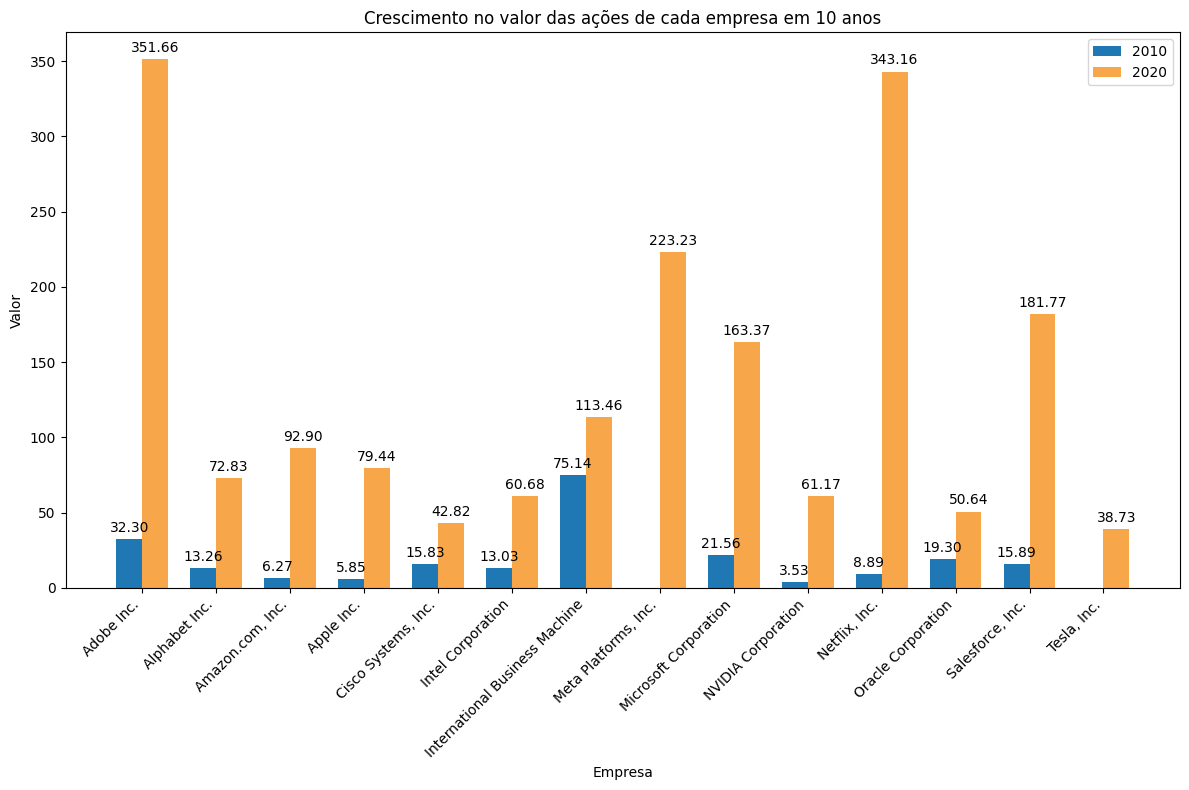

In [0]:
# graphical representation of the results
results_pd = results.toPandas()

results_pd['company'] = results_pd['company'].apply(lambda x: x[:30])
results_pd.sort_values(by='company', inplace=True)

companies = results_pd['company'].tolist()
values_2010 = results_pd['value_2010'].tolist()
values_2020 = results_pd['value_2020'].tolist()

colors = ['#1f77b4', '#F7A649']

bar_width = 0.35
index = np.arange(len(companies))

fig, ax = plt.subplots(figsize=(12, 8))
bars_2010 = ax.bar(index - bar_width/2, values_2010, bar_width, label='2010', color=colors[0])
bars_2020 = ax.bar(index + bar_width/2, values_2020, bar_width, label='2020', color=colors[1])

ax.set_xlabel('Empresa')
ax.set_ylabel('Valor')
ax.set_title('Crescimento no valor das ações de cada empresa em 10 anos')
ax.set_xticks(index)
ax.set_xticklabels(companies, rotation=45, ha='right')
ax.legend()

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars_2010)
autolabel(bars_2020)

fig.tight_layout()
plt.show()

In [0]:
#4. What is the average monthly transaction volume of the companies that grew the most in these 10 years? And of those that grew the least?
sql = """
    (SELECT TOP 10000
        b.company, 
        AVG(CAST(a.volume AS BIGINT)) AS volume, 
        c.month
    FROM stock_prices a
    INNER JOIN companies b ON a.stock_symbol = b.stock_symbol
    INNER JOIN dates c ON a.date = c.id
    WHERE b.company IN ('Netflix, Inc.', 'International Business Machines Corporation','Oracle Corporation', 'NVIDIA Corporation')
    AND c.full_date between '2010-01-29' and '2020-01-29'
    GROUP BY 
        b.company,
        c.month
    ORDER BY 
        b.company,
        c.month) AS tmp
"""

try:
    results = spark.read.jdbc(url=jdbcUrl, table=sql, properties=connectionProperties)
except AnalysisException as e:
    print(f"Error: {e}")

results.show(15)

+--------------------+--------+------+
|             company|  volume| month|
+--------------------+--------+------+
|International Bus...|12103475|201001|
|International Bus...| 6232574|201002|
|International Bus...| 6366833|201003|
|International Bus...| 7293429|201004|
|International Bus...| 9855631|201005|
|International Bus...| 7703271|201006|
|International Bus...| 7176556|201007|
|International Bus...| 5581551|201008|
|International Bus...| 5782532|201009|
|International Bus...| 6838085|201010|
|International Bus...| 5185007|201011|
|International Bus...| 4440403|201012|
|International Bus...| 6214892|201101|
|International Bus...| 4903400|201102|
|International Bus...| 5899180|201103|
+--------------------+--------+------+
only showing top 15 rows



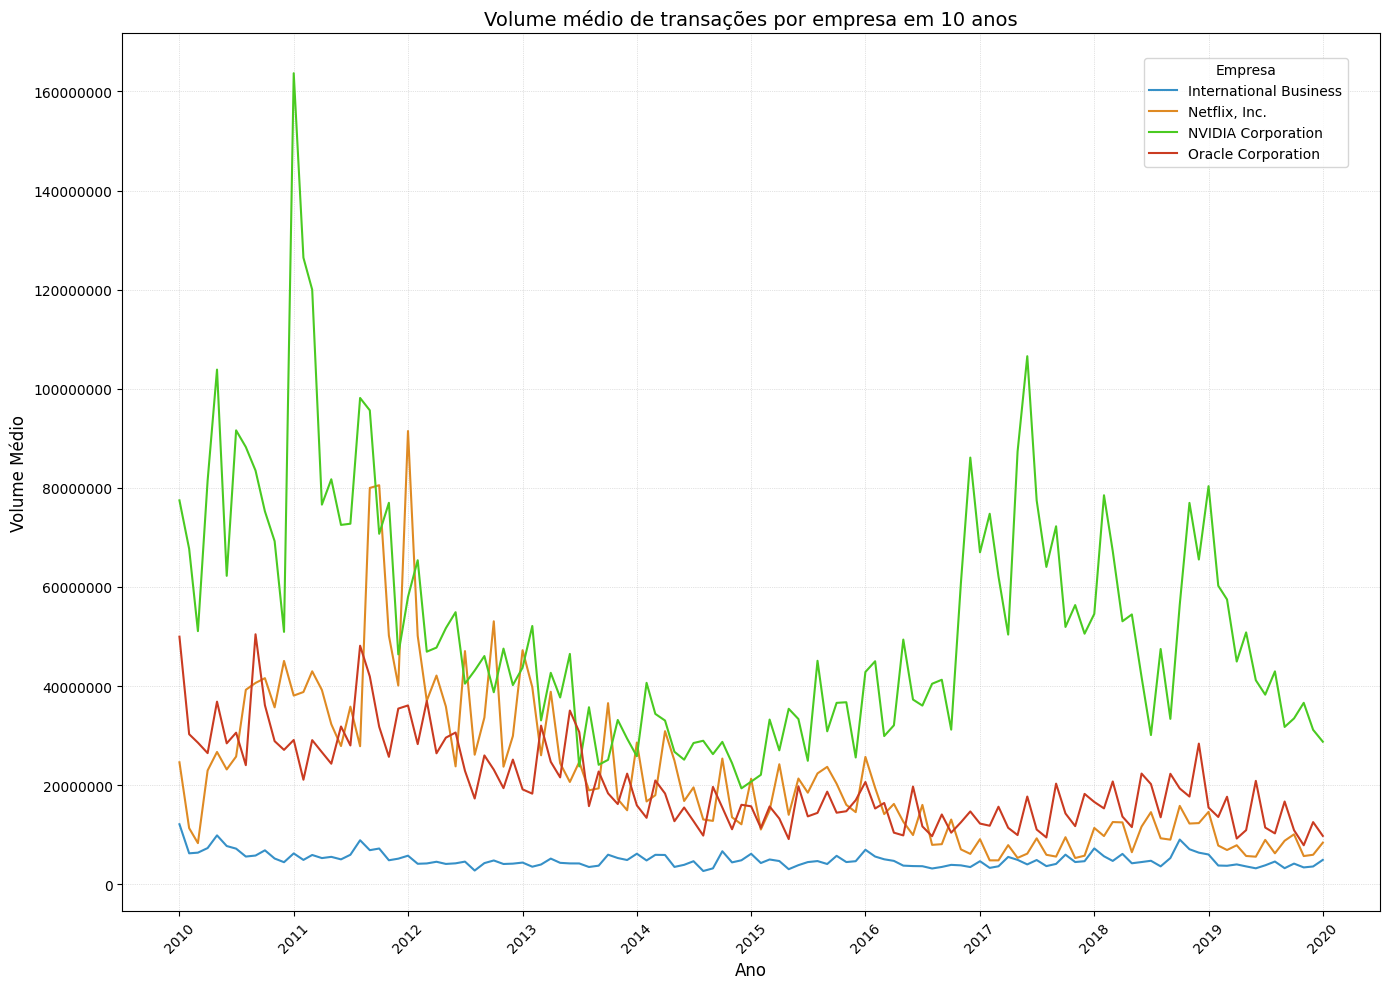

In [0]:
# graphical representation of the results
results_pd = results.toPandas()

results_pd['month'] = pd.to_datetime(results_pd['month'], format='%Y%m')
results_pd['company'] = results_pd['company'].apply(lambda x: x[:22])

fig, ax = plt.subplots(figsize=(14, 10))

colors = ['#3690C7', '#DF8A23', '#4ACA21', '#CA3B21']

for i, company in enumerate(results_pd['company'].unique()):
    company_data = results_pd[results_pd['company'] == company]
    ax.plot(company_data['month'], company_data['volume'], label=company, color=colors[i], linewidth=1.5)

ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Volume Médio', fontsize=12)
ax.set_title('Volume médio de transações por empresa em 10 anos', fontsize=14)

ax.legend(title='Empresa', fontsize=10, bbox_to_anchor=(0.98, 0.98), loc='upper right')

plt.xticks(rotation=45)
plt.yticks(fontsize=10)

def format_volume(x, pos):
    return '{:.0f}'.format(x) 

ax.yaxis.set_major_formatter(FuncFormatter(format_volume))
ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [0]:
#5. Which of these companies are newer to the market? What was the average quotation value of these companies in the last year?
sql = """
    (SELECT TOP 1000
        b.company, 
        a.adj_close, 
        c.full_date
    FROM stock_prices a
    INNER JOIN companies b ON a.stock_symbol = b.stock_symbol
    INNER JOIN dates c ON a.date = c.id
    WHERE b.company IN ('Meta Platforms, Inc.', 'Tesla, Inc.')
    AND c.full_date > '2021-12-31' AND c.full_date < '2023-01-01'
    ORDER BY 
        b.company,
        c.full_date) AS tmp
"""

try:
    results = spark.read.jdbc(url=jdbcUrl, table=sql, properties=connectionProperties)
except AnalysisException as e:
    print(f"Error: {e}")

results.show(15)

+--------------------+---------+-------------------+
|             company|adj_close|          full_date|
+--------------------+---------+-------------------+
|Meta Platforms, Inc.|   338.54|2022-01-03 00:00:00|
|Meta Platforms, Inc.|   336.53|2022-01-04 00:00:00|
|Meta Platforms, Inc.|   324.17|2022-01-05 00:00:00|
|Meta Platforms, Inc.|   332.46|2022-01-06 00:00:00|
|Meta Platforms, Inc.|   331.79|2022-01-07 00:00:00|
|Meta Platforms, Inc.|   328.07|2022-01-10 00:00:00|
|Meta Platforms, Inc.|   334.37|2022-01-11 00:00:00|
|Meta Platforms, Inc.|   333.26|2022-01-12 00:00:00|
|Meta Platforms, Inc.|   326.48|2022-01-13 00:00:00|
|Meta Platforms, Inc.|    331.9|2022-01-14 00:00:00|
|Meta Platforms, Inc.|   318.15|2022-01-18 00:00:00|
|Meta Platforms, Inc.|   319.59|2022-01-19 00:00:00|
|Meta Platforms, Inc.|   316.56|2022-01-20 00:00:00|
|Meta Platforms, Inc.|   303.17|2022-01-21 00:00:00|
|Meta Platforms, Inc.|   308.71|2022-01-24 00:00:00|
+--------------------+---------+--------------

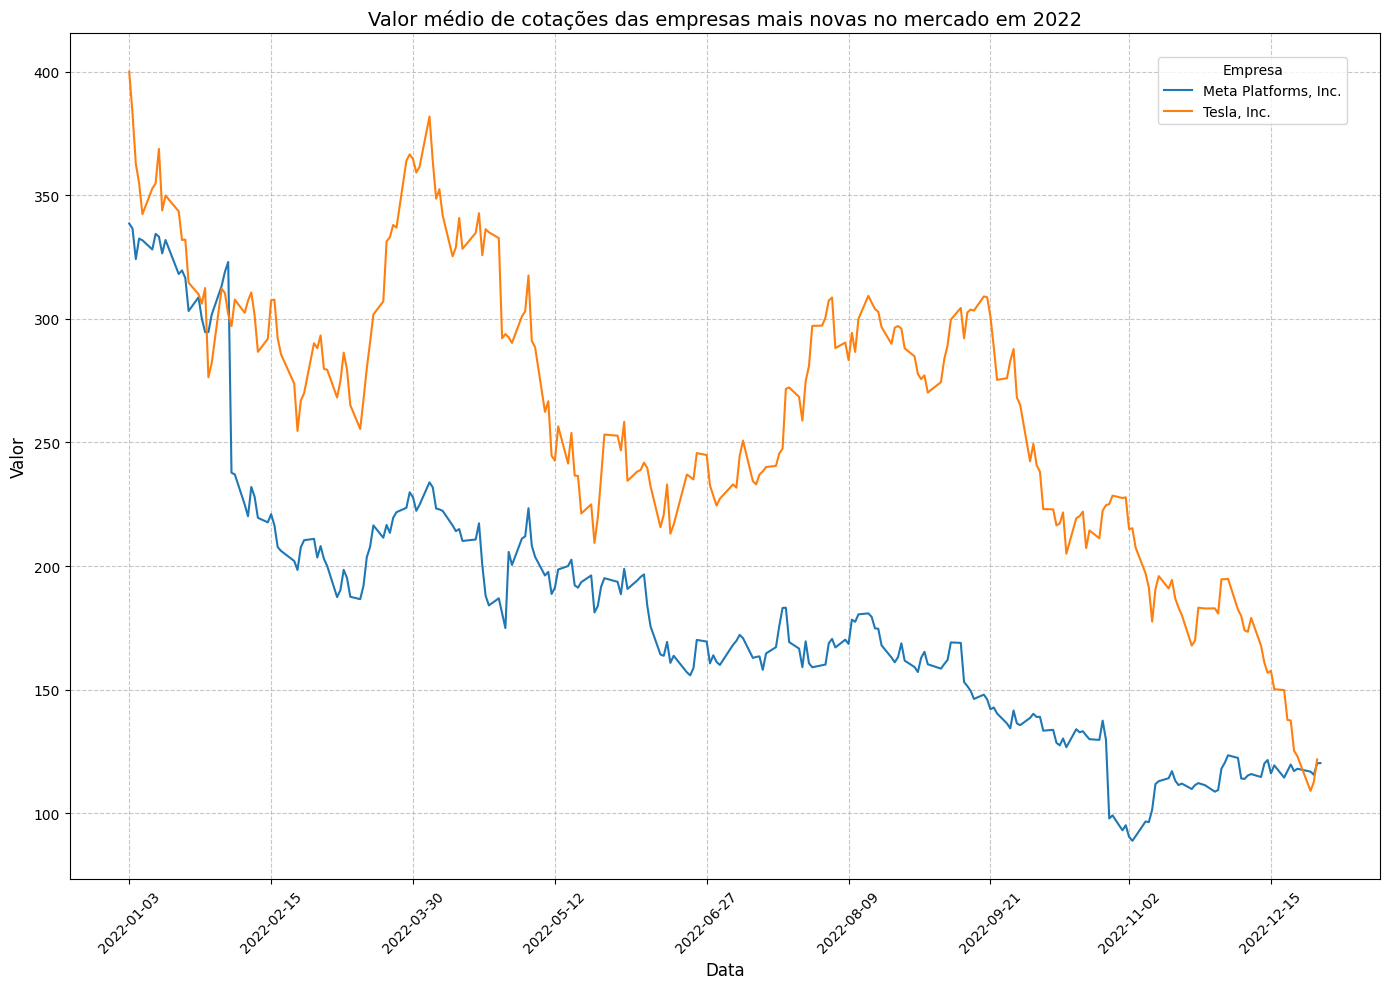

In [0]:
# graphical representation of the results
results_pd = results.toPandas()

fig, ax = plt.subplots(figsize=(14, 10))

for company in results_pd['company'].unique():
    company_data = results_pd[results_pd['company'] == company]
    ax.plot(company_data['full_date'], company_data['adj_close'], label=company)

ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)
ax.set_title('Valor médio de cotações das empresas mais novas no mercado em 2022', fontsize=14)
ax.legend(title='Empresa', fontsize=10, bbox_to_anchor=(0.98, 0.98), loc='upper right')
plt.xticks(rotation=45)

all_dates = results_pd['full_date'].unique()
date_ticks = all_dates[::30]
ax.set_xticks(date_ticks)

ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()